In [1]:
from model import Tacotron2
from hparams import Hparams
from text import text_to_sequence
from audio_processing import _custom_griffin_lim, _denormalize
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch

def get_model(checkpoint_path):
    model = Tacotron2(Hparams)
    checkpoint = torch.load(checkpoint_path, map_location=f'cuda:{0}')
    checkpoint['state_dict'] = {key.replace("module.", ""): value
                                for key, value in checkpoint['state_dict'].items()}
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model = model.cuda(0)
    return model

def get_text(text):
    sequences = torch.LongTensor(text_to_sequence(text)).unsqueeze(0)
    sequences = sequences.cuda(0)
    return sequences

def synthesis(model, text):
    model.eval()
    with torch.no_grad():
        outputs = model.inference(sequences)
        mel, gate, align = outputs[1:]
    return mel, gate, align

def visualize(mel, gate, align):
    plt.imshow(mel.squeeze(0).detach().cpu().numpy(), aspect='auto', origin='lower')
    plt.show()

    plt.plot(gate.squeeze(0).detach().cpu().numpy())
    plt.show()

    plt.imshow(align.squeeze(0).detach().cpu().numpy().T, aspect='auto', origin='lower')
    plt.show()

    mel_denorm = _denormalize(mel.squeeze(0).detach().cpu().numpy(), Hparams)

    Hparams.griffin_lim_iters = 60
    audio = _custom_griffin_lim(mel_denorm, Hparams)
    display(ipd.Audio(audio, rate=Hparams.sampling_rate, normalize=True, autoplay=False))


In [2]:
checkpoint_path = '/home/work/tacotron2/data/kss_v1/model_state/checkpoint_15000'
model = get_model(checkpoint_path)

input_text = '안녕하세요? 만나서 반갑습니다.'
sequences = get_text(input_text)

mel, gate, align = synthesis(model, sequences)

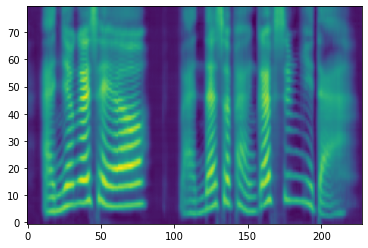

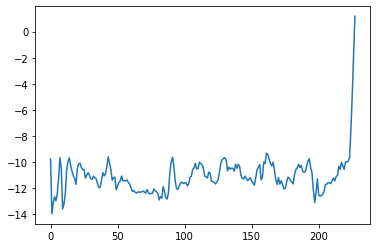

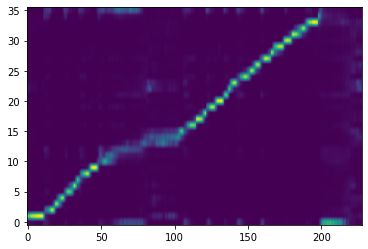

/home/choihk/work/tacotron2/audio_processing.py:319: FutureWarning: Pass sr=22050, n_fft=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(sampling_rate, n_fft, n_mels=num_mels,


In [3]:
visualize(mel, gate, align)